## PetFinder.my - Pawpularity Contest
---

In [1]:
import numpy as np
import pandas as pd

import gc

import cv2

# plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from tqdm.notebook import tqdm_notebook

from plotly.offline import init_notebook_mode, iplot
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

init_notebook_mode(connected=True)

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import torch.optim as optim

C:\Users\divye\miniconda3\envs\pet_finder_env\lib\site-packages\torchvision\io\image.py:11: UserWarning:

Failed to load image Python extension: Could not find module 'C:\Users\divye\miniconda3\envs\pet_finder_env\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.



In [2]:
train_df = pd.read_csv('../input/petfinder-pawpularity-score/train.csv')

In [3]:
train_df.shape

(9912, 14)

In [4]:
train_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [5]:
train_df.describe()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
count,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000
mean,0.027643,0.772599,0.903955,0.861582,0.009988,0.067797,0.129338,0.049637,0.166263,0.172014,0.061239,0.070420,38.039044
std,0.163957,0.419175,0.294668,0.345356,0.099444,0.251409,0.335591,0.217204,0.372335,0.377411,0.239780,0.255866,20.591990
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000
50%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.000000
75%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,46.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000


In [6]:
fig = px.histogram(train_df, x='Pawpularity')
fig.update_layout(autosize=False, width=700)
fig.show()

In [7]:
metadata = ["Subject Focus", "Eyes", "Face", "Near", "Action", "Accessory", \
            "Group", "Collage", "Human", "Occlusion", "Info", "Blur"]

fig = make_subplots(rows=2, cols=6)

for i, name in enumerate(metadata):
    row, col = i // 6, i % 6
    trace1 = go.Box(x=train_df['Near'], y=train_df['Pawpularity'], name=name)
    fig.append_trace(trace1, row = row + 1, col = col + 1)
    
fig.show()

In [8]:
# image related utility functions

def image_read(path):
    img = cv2.imread(path)
    if img is None:
        raise Exception("Unable to read an image")
    return img

def read_image_rgb(path):
    img = image_read(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def image_h_w(path):
    img = image_read(path)
    shape = img.shape
    return shape[0], shape[1]

In [9]:
train_df['path'] = train_df.apply(lambda x : '../input/petfinder-pawpularity-score/train/' + x['Id'] + ".jpg", axis=1)
train_df['image_h_w'] = train_df.apply(lambda x : image_h_w(x.path), axis=1)
train_df['height'] = train_df.apply(lambda x : x['image_h_w'][0], axis=1)
train_df['width'] = train_df.apply(lambda x : x['image_h_w'][1], axis=1)

In [10]:
fig = px.scatter(x=train_df['width'], y=train_df['height'])
fig.update_layout(autosize=False, width=700)
fig.show()

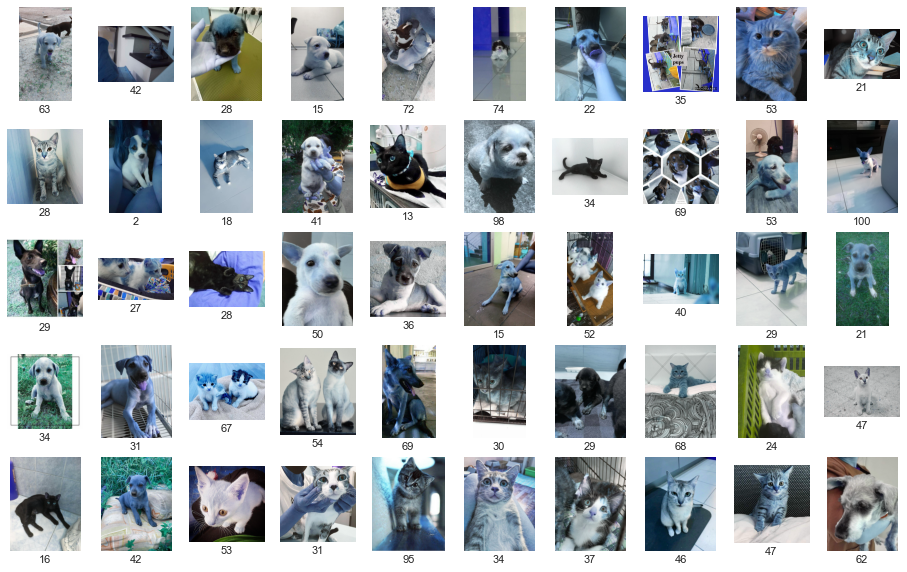

In [11]:
# Plot first 50 images
fig, ax = plt.subplots(5,10,figsize=(16, 10))
for i, (path, score) in enumerate(train_df[['path', 'Pawpularity']][:50].values.tolist()):
    row, col = i // 10, i % 10
    axis = ax[row][col]
    axis.imshow(image_read(path))
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel(score)
plt.show()

In [12]:
class PetDataset(Dataset):
    
    def __init__(self, paths, labels=None, transforms=None):
        self.paths = paths
        self.labels = labels
        self.transforms = transforms
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx : int):
        
        img = read_image_rgb(self.paths[idx])
        
        if self.transforms:
            img = self.transforms(img)
    
        # if we use for model inference  
        if self.labels is None:
            return img
        
        return img, self.labels[idx]
    

In [52]:
# Note:
# ToTensor() -> change channel order from (H x W x C) to (C x H x W), and scale from [0,255] -> [0,1]
# Normalize() -> mean, std, will convert to z-score, y = (x-mean)/std

data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


X_data = np.array(train_df.path)
y_data = np.array(train_df.Pawpularity)
y_data = y_data / 100.0
y_data = np.expand_dims(y_data, axis=1)

# simple train/test split

mask = np.random.rand(len(X_data)) <= 0.8

X_train = X_data[mask]
y_train = y_data[mask]

X_test = X_data[~mask]
y_test = y_data[~mask]


debug = True
train_batch_size = 8
test_batch_size = 4

if debug:
    X_train = X_train[:1000]
    y_train = y_train[:1000]
    X_test = X_test[:100]
    y_test = y_test[:100]

train_dataloader = DataLoader(PetDataset(X_train, y_train, data_transforms['train']), batch_size=train_batch_size)
test_dataloader = DataLoader(PetDataset(X_test, y_test, data_transforms['test']), batch_size=test_batch_size)

print(len(train_dataloader.dataset), len(test_dataloader.dataset))


1000 100


In [53]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [56]:
def sigmoid_fn(x):
    return 1/(1 + np.exp(-x))


def rmse_fn(predictions, targets):
    return np.sqrt(
        np.mean((predictions-targets)**2)
    )


class PetNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = models.resnet18()
        self.model.fc = nn.Linear(in_features=512, out_features=1)

    def forward(self, x):
        return self.model(x)


class PetTrainer:

    def __init__(self, net) -> None:
        self.net = net.to(device)
        self.loss_fn = nn.BCEWithLogitsLoss()
        self.optimizer_fn = optim.Adam(params=self.net.parameters())

    def train(self, data_loader):

        # model set to train mode
        self.net.train()

        total_loss = 0

        for img_batch, label_batch in tqdm_notebook(data_loader):

            img_batch, label_batch = \
                img_batch.to(device), label_batch.to(device)

            # reset params
            self.optimizer_fn.zero_grad()

            # forward
            output = self.net(img_batch)

            # compute loss and take backward
            loss_op = self.loss_fn(output, label_batch)
            loss_op.backward()

            # take optimizer step
            self.optimizer_fn.step()

            total_loss += loss_op.item()

        print(f"BCELoss: {total_loss / len(data_loader)}")

    def test(self, data_loader):

        self.net.eval()

        predict_ls, true_ls = [], []

        with torch.no_grad():
            for img_batch, label_batch in tqdm_notebook(data_loader):
                img_batch = img_batch.to(device)
                prediction = self.net(img_batch).cpu()
                predict_ls.extend(prediction.numpy())
                true_ls.extend(label_batch.numpy())

        predict_ls = np.array(predict_ls).ravel()
        predict_ls = sigmoid_fn(predict_ls) * 100

        true_ls = np.array(true_ls).ravel() * 100

        rmse = rmse_fn(predict_ls, true_ls)

        print(predict_ls[:50])
        print(true_ls[:50])
        print("RMSE:", rmse)

        pass

    def infer(self, data_loader):

        self.net.eval()

        pass


In [57]:
try: del net
except Exception: pass

gc.collect()
torch.cuda.empty_cache()

net = PetNet()
# print(net)

trainer = PetTrainer(net)
for i in range(5):
    trainer.train(train_dataloader)
trainer.test(test_dataloader)

  0%|          | 0/125 [00:00<?, ?it/s]

BCELoss: 0.6843286757718122


  0%|          | 0/125 [00:00<?, ?it/s]

BCELoss: 0.6731261106750371


  0%|          | 0/125 [00:00<?, ?it/s]

BCELoss: 0.672287255999185


  0%|          | 0/125 [00:00<?, ?it/s]

BCELoss: 0.6681998778903856


  0%|          | 0/125 [00:00<?, ?it/s]

BCELoss: 0.6677476510423421


  0%|          | 0/25 [00:00<?, ?it/s]

[33.589783  36.512558  36.833366  38.21131   27.511612  39.19105
 36.110264  38.10348   23.697216  35.381294  34.66635   12.053717
 37.74331   36.868282  24.103233  12.195704  37.564533  37.453377
 39.12489   32.845097  37.798615  36.70934   36.438663  37.943787
 36.364727  22.546293  18.667885   9.944407  36.547234  38.956047
 17.85998   28.910604  36.844757  36.88232   33.502804  34.873283
 31.051836  39.327766  34.946896  38.05638   36.934235  37.02929
 38.83599    5.7327027 37.86231   34.858265  10.122069  37.96819
 37.96834   39.771156 ]
[ 42. 100.  29.  21.  42.  34.  37.  46.  33.  46.  82.  50.  53.  41.
  23.  57.  31.  41.  49.  41.  91.  30.  15.  30.  43.  49.  23.  39.
  35.  36.  57.  12.  38.  22.  52.  71.  18.  35.  28.  15.  43.  39.
  29.   7.  30.  79.  17.  22.  62.  33.]
RMSE: 20.21782876361561
